# Optimizing the server routine without communication

I am optimizing the server routine without communication.

The benchmarks are run on different number of cores. The limit of the cores is handled by docker. The number of workers is equal to the number of processors.

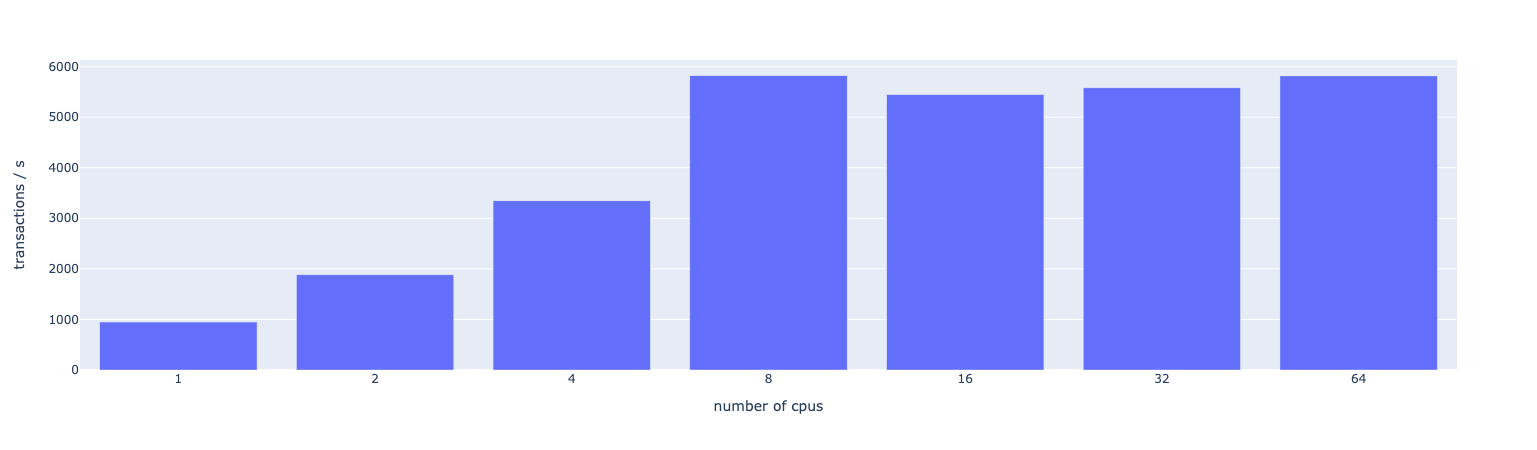

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

d1 = pd.read_csv("server-routine/data.csv")

fig = px.bar(x=d1["cpus"], y=1/(d1["nsop"]*10**-9))
fig.update_layout(xaxis_type='category')
fig.update_yaxes(title_text="transactions / s")
fig.update_xaxes(title_text="number of cpus")

fig.show()

That means that the server routine does not scale properly.

## Analysing the bottleneck

Server: 64-core general purpose AWS linux server.

### Block profiling

Using 1 core: `1core-block.svg`

Using 64 cores: `64cores-block.svg`

### Analysis result

We can see that my **hash function** is very inefficient. In my hash function I first print the struct (to a string), then hash the string. There must be a more efficient way.

## Fixing the bottleneck

Now using `encoding/gob` which streams into `crypto/sha3` directly.

Before:

```go
func HashValueSprintf(value Value) []byte {
	d := sha3.New256()
	value.Signatures = nil                   	// zero out signatures before hash
	d.Write([]byte(fmt.Sprintf("%v", value)))	// this may be slow!
	return d.Sum(nil)
}
```

After:

```go
func HashValue(value Value) []byte {
	value.Signatures = nil                    	// zero out signatures before hash
	d := sha3.New256()
	enc := gob.NewEncoder(d)
	enc.Encode(value)
	return d.Sum(nil)
}
```

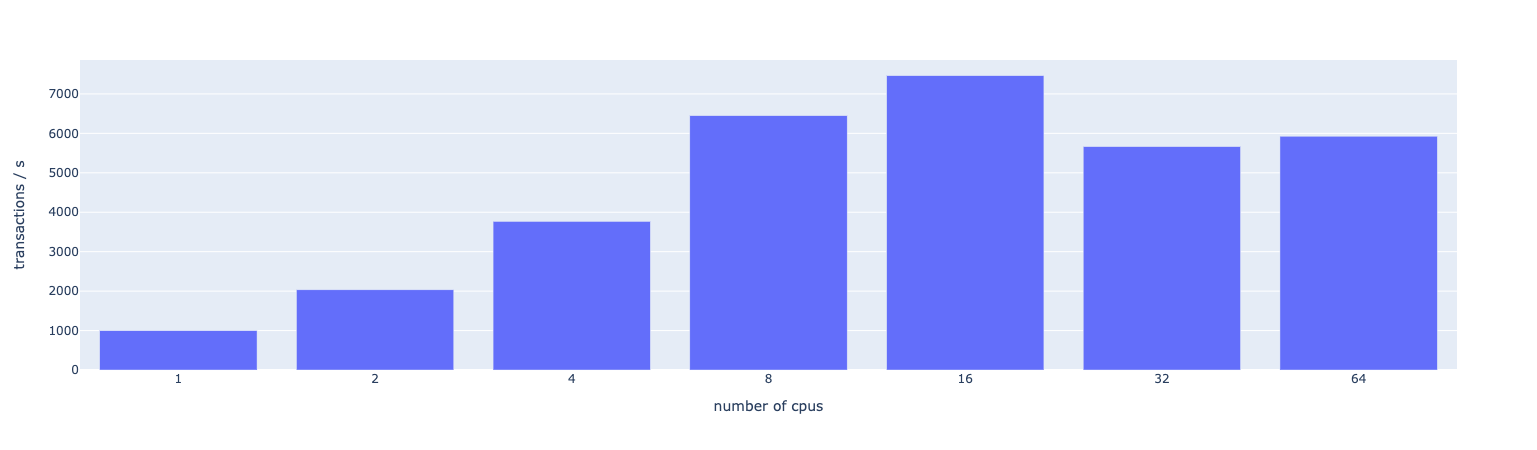

In [12]:
d1 = pd.read_csv("server-routine/data2.csv")

fig = px.bar(x=d1["cpus"], y=1/(d1["nsop"]*10**-9))
fig.update_layout(xaxis_type='category')
fig.update_yaxes(title_text="transactions / s")
fig.update_xaxes(title_text="number of cpus")

fig.show()

## Analysing the second bottleneck

### Block profiling

Using 1 core: `1core-block-2.svg`

Using 64 cores: `64cores-block-2.svg`